In [21]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes, Details
from msrest.authentication import CognitiveServicesCredentials

from PIL import Image
from collections import Counter

import os
import openai
import pandas as pd
import redis

from langchain.vectorstores import Redis
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import AzureChatOpenAI
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

from langchain.document_loaders import DataFrameLoader

In [3]:
# define our Microsoft Cognitive Services subscription key
SUBSCRIPTION_KEY = "11c0ce07c68d4bec86d72364155c0995"
# define the ACS endpoint
ENDPOINT_URL = "https://computer-vision-1.cognitiveservices.azure.com/"

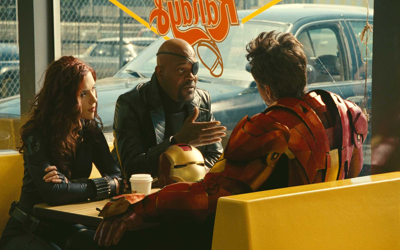

In [6]:
test_image = '../Data/iron_man_2.jpg'
display(Image.open(test_image).resize((400, 250)))

In [8]:
client = ComputerVisionClient(ENDPOINT_URL, CognitiveServicesCredentials(SUBSCRIPTION_KEY))

def analysis_image(image_path):
    # Specify features to be retrieved
    features = [VisualFeatureTypes.description,
                VisualFeatureTypes.tags,
                VisualFeatureTypes.categories,
                VisualFeatureTypes.brands,
                VisualFeatureTypes.objects,
                VisualFeatureTypes.adult,
                VisualFeatureTypes.faces,
                VisualFeatureTypes.color,
                VisualFeatureTypes.image_type]
    remote_image_details = [Details.celebrities]
    
    # Get image analysis
    with open(image_path, mode="rb") as image_data:
        analysis = client.analyze_image_in_stream(image_data , features,remote_image_details)
        
    return analysis

In [10]:
test_analysis = analysis_image(test_image)

In [42]:
def descripcion_imagen(analysis):
    # Get image description
    description = []
    tags = []
    categories = []
    brands = []
    objects = []
    conteo_objetos= []
    landmarks = []
    referencias = []
    for caption in analysis.description.captions:
        description.append(caption.text)
    # Get image tags
    for caption in analysis.tags:
        tags.append(caption.name)
    # Get image categories 
    for category in analysis.categories:
        categories.append(category.name)
        if category.detail:
            # Get landmarks in this category
            if category.detail.landmarks:
                for landmark in category.detail.landmarks:
                    if landmark not in landmarks:
                        landmarks.append(landmark)
    # If there were landmarks, list them
    if len(landmarks) > 0:
        for landmark in landmarks:
            referencias.append(landmark.name)  
    #Get image brands
    if len(analysis.brands) == 0:
        for caption in analysis.brands:
            brands.append(caption)
    else:
        for brand0 in analysis.brands:
            brands.append(brand0.name)
    # Get objects in the image
    for caption in analysis.objects:
        objects.append(caption.object_property)
    lista_group = Counter(objects)
    
    if len(list(lista_group)) > 0:
        for i in range(0,len(lista_group)):
            conteo_objetos.append(str(list(lista_group.values())[i])+" "+list(lista_group.keys())[i])
    # Get moderation ratings
    adult_content = analysis.adult.is_adult_content
    racy_content = analysis.adult.is_racy_content
    if adult_content == False:
        is_adult = "No adult content"
    else:
        is_adult = "is adult content"
            
    # Detect Image Types - local
    if analysis.image_type.clip_art_type == 0:
        imagen_type = "Image is not clip art."
    elif analysis.image_type.line_drawing_type == 1:
        imagen_type = "Image is ambiguously clip art."
    elif analysis.image_type.line_drawing_type == 2:
        imagen_type = "Image is normal clip art."
    else:
        imagen_type = "Image is good clip art."

    if analysis.image_type.line_drawing_type == 0:
        imagen_draw = "Image is not a line drawing."
    else:
        imagen_draw = "Image is a line drawing"

    # Print results of color scheme
    if analysis.color.is_bw_img == True:
        black_white = "is black and white image"
    else:
        black_white = "is not black and white image"
    colors = analysis.color.dominant_colors
    

    resumen = f'Description: {", ".join(description)}\nTags: {", ".join(tags)}\nCategories: {", ".join(categories)}\nbrands: {", ".join(brands)}\nNumber of people and objects in the image: {", ".join(conteo_objetos)}\nAdult content: {is_adult}\nlandmarks: {", ".join(referencias)}\nImagen clip art: {imagen_type}\nDrawing: {imagen_draw}\nBlack and white: {black_white}\nDominant Colors: {",".join(colors)}'
    
    return resumen

In [43]:
descripcion_imagen(test_analysis)

'Description: a group of people sitting at a table\nTags: clothing, person, human face, vehicle, land vehicle, man, sitting, people, woman, outdoor, street\nCategories: others_, outdoor_, people_many\nbrands: \nNumber of people and objects in the image: 2 person, 1 Vehicle\nAdult content: No adult content\nlandmarks: \nImagen clip art: Image is not clip art.\nDrawing: Image is not a line drawing.\nBlack and white: is not black and white image\nDominant Colors: Black,Brown,Yellow'

In [44]:
def get_text_description_of_image(input_image_path):
    
    analysis_input_image = analysis_image(input_image_path)
    
    output_description = descripcion_imagen(analysis_input_image)
    
    return output_description

In [45]:
get_text_description_of_image("../Data/keanu.jpg")

'Description: Keanu Reeves with long hair\nTags: human face, person, human beard, man, smile, portrait, outdoor\nCategories: people_portrait\nbrands: \nNumber of people and objects in the image: 1 person\nAdult content: No adult content\nlandmarks: \nImagen clip art: Image is not clip art.\nDrawing: Image is not a line drawing.\nBlack and white: is not black and white image\nDominant Colors: Brown'

In [46]:
image_description = get_text_description_of_image(test_image)
print(image_description)

Description: a group of people sitting at a table
Tags: clothing, person, human face, vehicle, land vehicle, man, sitting, people, woman, outdoor, street
Categories: others_, outdoor_, people_many
brands: 
Number of people and objects in the image: 2 person, 1 Vehicle
Adult content: No adult content
landmarks: 
Imagen clip art: Image is not clip art.
Drawing: Image is not a line drawing.
Black and white: is not black and white image
Dominant Colors: Black,Brown,Yellow


In [47]:
api_type = "azure"
api_base_url = "https://openaidemonubiral.openai.azure.com/"
api_version = "2023-03-15-preview"
azure_api_key = "ff5c606c134e4d1dae3426a412df834a"

openai.api_type = api_type
openai.api_base = api_base_url
openai.api_version = api_version
openai.api_key = azure_api_key

os.environ["OPENAI_API_BASE"] = api_base_url
os.environ["OPENAI_API_KEY"] = azure_api_key

#openai.Deployment.list()

embeddings_azure = OpenAIEmbeddings(model="text-embedding-ada-002", chunk_size=1)

llm_azure_chatgpt = AzureChatOpenAI(
    deployment_name="nubiral-lab-01", 
    temperature=0, 
    openai_api_version=api_version)

In [50]:
image_data_dict = {
    "source": test_image,
    "image_description": image_description
}

image_data_df = pd.DataFrame([image_data_dict])

image_data_df

,source,image_description
0,../Data/iron_man_2.jpg,Description: a group of people sitting at a ta...


In [51]:
loader = DataFrameLoader(image_data_df, page_content_column="image_description")
docs = loader.load()

In [52]:
docs

[Document(page_content='Description: a group of people sitting at a table\nTags: clothing, person, human face, vehicle, land vehicle, man, sitting, people, woman, outdoor, street\nCategories: others_, outdoor_, people_many\nbrands: \nNumber of people and objects in the image: 2 person, 1 Vehicle\nAdult content: No adult content\nlandmarks: \nImagen clip art: Image is not clip art.\nDrawing: Image is not a line drawing.\nBlack and white: is not black and white image\nDominant Colors: Black,Brown,Yellow', metadata={'source': '../Data/iron_man_2.jpg'})]

In [53]:
redis_url = "rediss://:7faRnxC4vBcEWoGNuB9hN6gnXxdYpdRtM5KhcGRq0d8=@vectordb.eastus2.redisenterprise.cache.azure.net:10000"
index_name = 'test_image'

rds = Redis.from_documents(docs, embeddings_azure, redis_url=redis_url,  index_name=index_name)

In [54]:
k=5
retriever_db = rds.as_retriever(search_type="similarity", search_kwargs={"k": k})

In [55]:
chain_type = "stuff"

qa = RetrievalQA.from_chain_type(llm=llm_azure_chatgpt, chain_type=chain_type, retriever=retriever_db, return_source_documents=True)

In [58]:
query = "cuantas personas hay en la imagen?"
result = qa({"query": query})

result['result']

'Hay dos personas en la imagen.'

In [60]:
result['source_documents']

[Document(page_content='Description: a group of people sitting at a table\nTags: clothing, person, human face, vehicle, land vehicle, man, sitting, people, woman, outdoor, street\nCategories: others_, outdoor_, people_many\nbrands: \nNumber of people and objects in the image: 2 person, 1 Vehicle\nAdult content: No adult content\nlandmarks: \nImagen clip art: Image is not clip art.\nDrawing: Image is not a line drawing.\nBlack and white: is not black and white image\nDominant Colors: Black,Brown,Yellow', metadata={'source': '../Data/iron_man_2.jpg'})]